In [3]:
!pip install opencv_transforms
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For utilities
import time, sys, os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets
from tqdm.notebook import tqdm
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import torchvision
# For conversion
import cv2
import torchvision
import opencv_transforms.transforms as TF

# For everything
import torch
import torch.nn as nn
import torchvision.utils as vutils

# For our model
import torchvision.models

# To ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("The gpu to be used : {}".format(torch.cuda.get_device_name(0)))
else:
    print("No gpu detected")

The gpu to be used : Tesla P100-PCIE-16GB


In [8]:
import cv2
import numpy as np
import torch
import torchvision
import opencv_transforms.functional as FF
from torchvision import datasets
from PIL import Image

def color_cluster(img, nclusters=9):
    """
    Apply K-means clustering to the input image

    Args:
        img: Numpy array which has shape of (H, W, C)
        nclusters: # of clusters (default = 9)

    Returns:
        color_palette: list of 3D numpy arrays which have same shape of that of input image
        e.g. If input image has shape of (256, 256, 3) and nclusters is 4, the return color_palette is [color1, color2, color3, color4]
            and each component is (256, 256, 3) numpy array.
            
    Note:
        K-means clustering algorithm is quite computaionally intensive.
        Thus, before extracting dominant colors, the input images are resized to x0.25 size.
    """
    img_size = img.shape
    small_img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    sample = small_img.reshape((-1, 3))
    sample = np.float32(sample)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_PP_CENTERS
    
    _, _, centers = cv2.kmeans(sample, nclusters, None, criteria, 10, flags)
    centers = np.uint8(centers)
    color_palette = []
    
    for i in range(0, nclusters):
        dominant_color = np.zeros(img_size, dtype='uint8')
        dominant_color[:,:,:] = centers[i]
        color_palette.append(dominant_color)
    
    return color_palette

class PairImageFolder(datasets.ImageFolder):   
    """
    A generic data loader where the images are arranged in this way: ::

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    
    This class works properly for paired image in form of [sketch, color_image]

    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
        sketch_net: The network to convert color image to sketch image
        ncluster: Number of clusters when extracting color palette.

     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    
     Getitem:
        img_edge: Edge image
        img: Color Image
        color_palette: Extracted color paltette
    """
    def __init__(self, root, transform, sketch_net, ncluster):
        super(PairImageFolder, self).__init__(root, transform)
        self.ncluster = ncluster
        self.sketch_net = sketch_net
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    def __getitem__(self, index):
        path, label = self.imgs[index]
        img = self.loader(path)
        img = np.asarray(img)
        img = img[:, 0:512, :]
        img = self.transform(img)
        color_palette = color_cluster(img, nclusters=self.ncluster)
        img = self.make_tensor(img)
        
        with torch.no_grad():
            img_edge = self.sketch_net(img.unsqueeze(0).to(self.device)).squeeze().permute(1,2,0).cpu().numpy()
            img_edge = FF.to_grayscale(img_edge, num_output_channels=3)
            img_edge = FF.to_tensor(img_edge)
            
        for i in range(0, len(color_palette)):
            color = color_palette[i]
            color_palette[i] = self.make_tensor(color)

        return img_edge, img, color_palette
    
    def make_tensor(self, img):
        img = FF.to_tensor(img)
        img = FF.normalize(img, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        return img
    
class GetImageFolder(datasets.ImageFolder):   
    """
    A generic data loader where the images are arranged in this way: ::

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png

    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
        sketch_net: The network to convert color image to sketch image
        ncluster: Number of clusters when extracting color palette.

     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    
     Getitem:
        img_edge: Edge image
        img: Color Image
        color_palette: Extracted color paltette
    """
    def __init__(self, root, transform, sketch_net, ncluster):
        super(GetImageFolder, self).__init__(root, transform)
        self.ncluster = ncluster
        self.sketch_net = sketch_net
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    def __getitem__(self, index):
        path, label = self.imgs[index]
        img = self.loader(path)
        img = np.asarray(img)
        img = self.transform(img)
        color_palette = color_cluster(img, nclusters=self.ncluster)
        img = self.make_tensor(img)
        
        with torch.no_grad():
            img_edge = self.sketch_net(img.unsqueeze(0).to(self.device)).squeeze().permute(1,2,0).cpu().numpy()
            img_edge = FF.to_grayscale(img_edge, num_output_channels=3)
            img_edge = FF.to_tensor(img_edge)
            
        for i in range(0, len(color_palette)):
            color = color_palette[i]
            color_palette[i] = self.make_tensor(color)

        return img_edge, img, color_palette
    
    def make_tensor(self, img):
        img = FF.to_tensor(img)
        img = FF.normalize(img, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        return img

In [9]:
import torch
import torch.nn as nn
import os

__all__ = [
    'Color2Sketch', 'Sketch2Color', 'Discriminator', 
]

class ApplyNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))

    def forward(self, x, noise=None):
        if noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        return x + self.weight.view(1, -1, 1, 1) * noise.to(x.device)

class Conv2d_WS(nn.Conv2d):
    def __init__(self, in_chan, out_chan, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_chan, out_chan, kernel_size, stride, padding, dilation, groups, bias)
    
    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,keepdim=True).mean(dim=3, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1,1,1,1)+1e-5
        weight = weight / std.expand_as(weight)
        return torch.nn.functional.conv2d(x, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, sample=None):
        super(ResidualBlock, self).__init__()
        self.ic = in_channels
        self.oc = out_channels
        self.conv1 = Conv2d_WS(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(32, out_channels)
        self.conv2 = Conv2d_WS(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(32, out_channels)
        self.convr = Conv2d_WS(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bnr = nn.GroupNorm(32, out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.sample = sample
        if self.sample == 'down':
            self.sampling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        elif self.sample == 'up':
            self.sampling = nn.Upsample(scale_factor=2, mode='nearest')
        
    def forward(self, x):
        if self.ic != self.oc:
            residual = self.convr(x)
            residual = self.bnr(residual)
        else:
            residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        if self.sample is not None:
            out = self.sampling(out)
        return out

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            Conv2d_WS(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.GroupNorm(32, F_int)
            )
        
        self.W_x = nn.Sequential(
            Conv2d_WS(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.GroupNorm(32, F_int)
        )

        self.psi = nn.Sequential(
            Conv2d_WS(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.InstanceNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi    
    
class Color2Sketch(nn.Module):
    def __init__(self, nc=3, pretrained=False):
        super(Color2Sketch, self).__init__()
        class Encoder(nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                # Build ResNet and change first conv layer to accept single-channel input
                self.layer1 = ResidualBlock(nc, 64, sample='down')
                self.layer2 = ResidualBlock(64, 128, sample='down')
                self.layer3 = ResidualBlock(128, 256, sample='down')
                self.layer4 = ResidualBlock(256, 512, sample='down')
                self.layer5 = ResidualBlock(512, 512, sample='down')
                self.layer6 = ResidualBlock(512, 512, sample='down')
                self.layer7 = ResidualBlock(512, 512, sample='down')
                
            def forward(self, input_image):
                # Pass input through ResNet-gray to extract features
                x0 = input_image # nc * 256 * 256 
                x1 = self.layer1(x0) # 64 * 128 * 128 
                x2 = self.layer2(x1) # 128 * 64 * 64
                x3 = self.layer3(x2) # 256 * 32 * 32 
                x4 = self.layer4(x3) # 512 * 16 * 16 
                x5 = self.layer5(x4) # 512 * 8 * 8 
                x6 = self.layer6(x5) # 512 * 4 * 4
                x7 = self.layer7(x6) # 512 * 2 * 2

                return x1, x2, x3, x4, x5, x6, x7

        class Decoder(nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
                # Convolutional layers and upsampling     
                self.noise7 = ApplyNoise(512)
                self.layer7_up = ResidualBlock(512, 512, sample='up')
                
                self.Att6 = Attention_block(F_g=512,F_l=512,F_int=256)
                self.layer6 = ResidualBlock(1024, 512, sample=None)
                self.noise6 = ApplyNoise(512)
                self.layer6_up = ResidualBlock(512, 512, sample='up')
                
                self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
                self.layer5 = ResidualBlock(1024, 512, sample=None)
                self.noise5 = ApplyNoise(512)
                self.layer5_up = ResidualBlock(512, 512, sample='up')
                
                self.Att4 = Attention_block(F_g=512,F_l=512,F_int=256)
                self.layer4 = ResidualBlock(1024, 512, sample=None)
                self.noise4 = ApplyNoise(512)
                self.layer4_up = ResidualBlock(512, 256, sample='up')
                
                self.Att3 = Attention_block(F_g=256,F_l=256,F_int=128)
                self.layer3 = ResidualBlock(512, 256, sample=None)
                self.noise3 = ApplyNoise(256)
                self.layer3_up = ResidualBlock(256, 128, sample='up')
                
                self.Att2 = Attention_block(F_g=128,F_l=128,F_int=64)
                self.layer2 = ResidualBlock(256, 128, sample=None)
                self.noise2 = ApplyNoise(128)
                self.layer2_up = ResidualBlock(128, 64, sample='up')
                
                self.Att1 = Attention_block(F_g=64,F_l=64,F_int=32)
                self.layer1 = ResidualBlock(128, 64, sample=None)
                self.noise1 = ApplyNoise(64)
                self.layer1_up = ResidualBlock(64, 32, sample='up')   
                
                self.noise0 = ApplyNoise(32)
                self.layer0 = Conv2d_WS(32, 3, kernel_size=3, stride=1, padding=1)
                self.activation = nn.ReLU(inplace=True)
                self.tanh = nn.Tanh()

            def forward(self, midlevel_input): #, global_input):
                x1, x2, x3, x4, x5, x6, x7 = midlevel_input
                
                x = self.noise7(x7)                
                x = self.layer7_up(x) # 512 * 4 * 4

                x6 = self.Att6(g=x,x=x6)
                x = torch.cat((x, x6), dim=1) # 1024 * 4 * 4
                x = self.layer6(x) # 512 * 4 * 4
                x = self.noise6(x)
                x = self.layer6_up(x) # 512 * 8 * 8 
                
                x5 = self.Att5(g=x,x=x5)
                x = torch.cat((x, x5), dim=1) # 1024 * 8 * 8
                x = self.layer5(x) # 512 * 8 * 8
                x = self.noise5(x)
                x = self.layer5_up(x) # 512 * 16 * 16 

                x4 = self.Att4(g=x,x=x4)
                x = torch.cat((x, x4), dim=1) # 1024 * 16 * 16
                x = self.layer4(x) # 512 * 16 * 16
                x = self.noise4(x)
                x = self.layer4_up(x) # 256 * 32 * 32 
                
                x3 = self.Att3(g=x,x=x3)
                x = torch.cat((x, x3), dim=1) # 512 * 32 * 32
                x = self.layer3(x) # 256 * 32 * 32 
                x = self.noise3(x)
                x = self.layer3_up(x) # 128 * 64 * 64 
                
                x2 = self.Att2(g=x,x=x2)
                x = torch.cat((x, x2), dim=1) # 256 * 64 * 64 
                x = self.layer2(x) # 128 * 64 * 64 
                x = self.noise2(x)
                x = self.layer2_up(x) # 64 * 128 * 128 
                
                x1 = self.Att1(g=x,x=x1)
                x = torch.cat((x, x1), dim=1) # 128 * 128 * 128
                x = self.layer1(x) # 64 * 128 * 128 
                x = self.noise1(x)
                x = self.layer1_up(x) # 32 * 256 * 256
                
                x = self.noise0(x)
                x = self.layer0(x) # 3 * 256 * 256
                x = self.tanh(x)

                return x

        self.encoder = Encoder()
        self.decoder = Decoder()
        if pretrained:
            print('Loading pretrained {0} model...'.format('Color2Sketch'), end=' ')
            #assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
            checkpoint = torch.load('/kaggle/input/aicolorization/checkpoint/color2edge/ckpt.pth')
            self.load_state_dict(checkpoint['netG'], strict=True)
            print("Done!")
        else:
            self.apply(weights_init)
            print('Weights of {0} model are initialized'.format('Color2Sketch'))
            
    def forward(self, inputs):
        encode = self.encoder(inputs)
        output = self.decoder(encode)
        
        return output
    
class Sketch2Color(nn.Module):
    def __init__(self, nc=3, pretrained=False):
        super(Sketch2Color, self).__init__()
        class Encoder(nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                # Build ResNet and change first conv layer to accept single-channel input
                self.layer1 = ResidualBlock(nc, 64, sample='down')
                self.layer2 = ResidualBlock(64, 128, sample='down')
                self.layer3 = ResidualBlock(128, 256, sample='down')
                self.layer4 = ResidualBlock(256, 512, sample='down')
                self.layer5 = ResidualBlock(512, 512, sample='down')
                self.layer6 = ResidualBlock(512, 512, sample='down')
                self.layer7 = ResidualBlock(512, 512, sample='down')
                
            def forward(self, input_image):
                # Pass input through ResNet-gray to extract features
                x0 = input_image # nc * 256 * 256 
                x1 = self.layer1(x0) # 64 * 128 * 128 
                x2 = self.layer2(x1) # 128 * 64 * 64
                x3 = self.layer3(x2) # 256 * 32 * 32 
                x4 = self.layer4(x3) # 512 * 16 * 16 
                x5 = self.layer5(x4) # 512 * 8 * 8 
                x6 = self.layer6(x5) # 512 * 4 * 4
                x7 = self.layer7(x6) # 512 * 2 * 2

                return x1, x2, x3, x4, x5, x6, x7

        class Decoder(nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
                # Convolutional layers and upsampling     
                self.noise7 = ApplyNoise(512)
                self.layer7_up = ResidualBlock(512, 512, sample='up')
                
                self.Att6 = Attention_block(F_g=512,F_l=512,F_int=256)
                self.layer6 = ResidualBlock(1024, 512, sample=None)
                self.noise6 = ApplyNoise(512)
                self.layer6_up = ResidualBlock(512, 512, sample='up')
                
                self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
                self.layer5 = ResidualBlock(1024, 512, sample=None)
                self.noise5 = ApplyNoise(512)
                self.layer5_up = ResidualBlock(512, 512, sample='up')
                
                self.Att4 = Attention_block(F_g=512,F_l=512,F_int=256)
                self.layer4 = ResidualBlock(1024, 512, sample=None)
                self.noise4 = ApplyNoise(512)
                self.layer4_up = ResidualBlock(512, 256, sample='up')
                
                self.Att3 = Attention_block(F_g=256,F_l=256,F_int=128)
                self.layer3 = ResidualBlock(512, 256, sample=None)
                self.noise3 = ApplyNoise(256)
                self.layer3_up = ResidualBlock(256, 128, sample='up')
                
                self.Att2 = Attention_block(F_g=128,F_l=128,F_int=64)
                self.layer2 = ResidualBlock(256, 128, sample=None)
                self.noise2 = ApplyNoise(128)
                self.layer2_up = ResidualBlock(128, 64, sample='up')
                
                self.Att1 = Attention_block(F_g=64,F_l=64,F_int=32)
                self.layer1 = ResidualBlock(128, 64, sample=None)
                self.noise1 = ApplyNoise(64)
                self.layer1_up = ResidualBlock(64, 32, sample='up')   
                
                self.noise0 = ApplyNoise(32)
                self.layer0 = Conv2d_WS(32, 3, kernel_size=3, stride=1, padding=1)
                self.activation = nn.ReLU(inplace=True)
                self.tanh = nn.Tanh()

            def forward(self, midlevel_input): #, global_input):
                x1, x2, x3, x4, x5, x6, x7 = midlevel_input
                
                x = self.noise7(x7)                
                x = self.layer7_up(x) # 512 * 4 * 4

                x6 = self.Att6(g=x,x=x6)
                x = torch.cat((x, x6), dim=1) # 1024 * 4 * 4
                x = self.layer6(x) # 512 * 4 * 4
                x = self.noise6(x)
                x = self.layer6_up(x) # 512 * 8 * 8 
                
                x5 = self.Att5(g=x,x=x5)
                x = torch.cat((x, x5), dim=1) # 1024 * 8 * 8
                x = self.layer5(x) # 512 * 8 * 8
                x = self.noise5(x)
                x = self.layer5_up(x) # 512 * 16 * 16 

                x4 = self.Att4(g=x,x=x4)
                x = torch.cat((x, x4), dim=1) # 1024 * 16 * 16
                x = self.layer4(x) # 512 * 16 * 16
                x = self.noise4(x)
                x = self.layer4_up(x) # 256 * 32 * 32 
                
                x3 = self.Att3(g=x,x=x3)
                x = torch.cat((x, x3), dim=1) # 512 * 32 * 32
                x = self.layer3(x) # 256 * 32 * 32 
                x = self.noise3(x)
                x = self.layer3_up(x) # 128 * 64 * 64 
                
                x2 = self.Att2(g=x,x=x2)
                x = torch.cat((x, x2), dim=1) # 256 * 64 * 64 
                x = self.layer2(x) # 128 * 64 * 64 
                x = self.noise2(x)
                x = self.layer2_up(x) # 64 * 128 * 128 
                
                x1 = self.Att1(g=x,x=x1)
                x = torch.cat((x, x1), dim=1) # 128 * 128 * 128
                x = self.layer1(x) # 64 * 128 * 128 
                x = self.noise1(x)
                x = self.layer1_up(x) # 32 * 256 * 256
                
                x = self.noise0(x)
                x = self.layer0(x) # 3 * 256 * 256
                x = self.tanh(x)

                return x

        self.encoder = Encoder()
        self.decoder = Decoder()
        if pretrained:
            print('Loading pretrained {0} model...'.format('Sketch2Color'), end=' ')
            # assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
            checkpoint = torch.load('/kaggle/input/aicolorization/checkpoint/edge2color/ckpt.pth')
            self.load_state_dict(checkpoint['netG'], strict=True)
            print("Done!")
        else:
            self.apply(weights_init)
            print('Weights of {0} model are initialized'.format('Sketch2Color'))
            
    def forward(self, inputs):
        encode = self.encoder(inputs)
        output = self.decoder(encode)
        
        return output
    
class Discriminator(nn.Module):
    def __init__(self, nc=6, pretrained=False):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.utils.spectral_norm(nn.Conv2d(nc, 64, kernel_size=4, stride=2, padding=1))
        self.bn1 = nn.GroupNorm(32, 64)
        self.conv2 = torch.nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1))
        self.bn2 = nn.GroupNorm(32,128)
        self.conv3 = torch.nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1))
        self.bn3 = nn.GroupNorm(32, 256)
        self.conv4 = torch.nn.utils.spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1))
        self.bn4 = nn.GroupNorm(32, 512)
        self.conv5 = torch.nn.utils.spectral_norm(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))               
        self.activation = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        
        if pretrained:
            pass
        else:
            self.apply(weights_init)
            print('Weights of {0} model are initialized'.format('Discriminator'))

    def forward(self, base, unknown):
        input = torch.cat((base, unknown), dim=1)
        x = self.activation(self.conv1(input))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.bn4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))

        return x.mean((2,3))

# To initialize model weights
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('Conv2d_WS') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    elif classname.find('GroupNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    else:
        pass

In [10]:
with torch.no_grad():
    netC2S = Color2Sketch(pretrained=True).to(device)
    netC2S.eval()

Loading pretrained Color2Sketch model... Done!


In [16]:
# batch_size. number of cluster
batch_size = 1
ncluster = 9

# Validation 
print('Loading Validation data...', end=' ')
val_transforms = TF.Compose([
    TF.Resize(512),
    ])
val_imagefolder = PairImageFolder('/kaggle/input/aaaaaa', val_transforms, netC2S, ncluster)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=batch_size, shuffle=False)
print("Done!")
print("Validation data size : {}".format(len(val_imagefolder)))


# Test
print('Loading Test data...', end=' ')
test_transforms = TF.Compose([
    TF.Resize(512),
    ])
test_imagefolder = GetImageFolder('/kaggle/input/bbbbbb', test_transforms, netC2S, ncluster)
test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=batch_size, shuffle=False)
print("Done!")
print("Test data size : {}".format(len(test_imagefolder)))

# Reference
print('Loading Reference data...', end=' ')
refer_transforms = TF.Compose([
    TF.Resize(512),
    ])
refer_imagefolder = GetImageFolder('/kaggle/input/myrefer', refer_transforms, netC2S, ncluster)
refer_loader = torch.utils.data.DataLoader(refer_imagefolder, batch_size=1, shuffle=False)
refer_batch = next(iter(refer_loader))
print("Done!")
print("Reference data size : {}".format(len(refer_imagefolder)))

Loading Validation data... Done!
Validation data size : 1
Loading Test data... Done!
Test data size : 1
Loading Reference data... Done!
Reference data size : 1


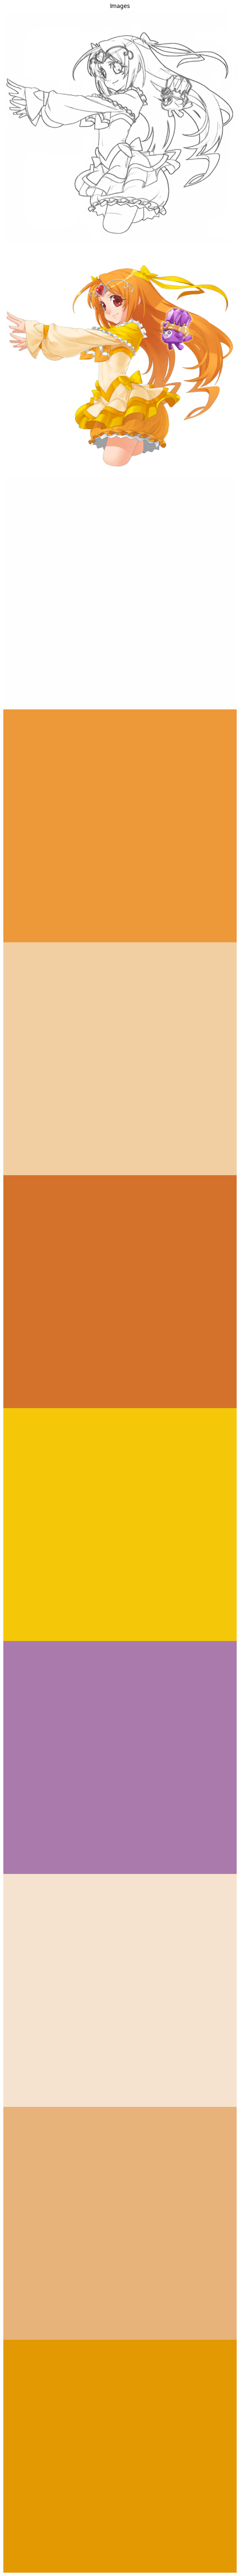

In [17]:
temp_batch_iter = iter(refer_loader)
temp_batch = next(temp_batch_iter)
edge = temp_batch[0]
color = temp_batch[1]
color_palette = temp_batch[2]

plt.figure(figsize=(16, 100))
result =torch.cat([edge, color]+color_palette,dim=-2)
plt.imshow(np.transpose(vutils.make_grid(result, nrow=6, padding=5, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Images")
plt.show()

Loading pretrained Sketch2Color model... Done!
Number of parameters: 63504297


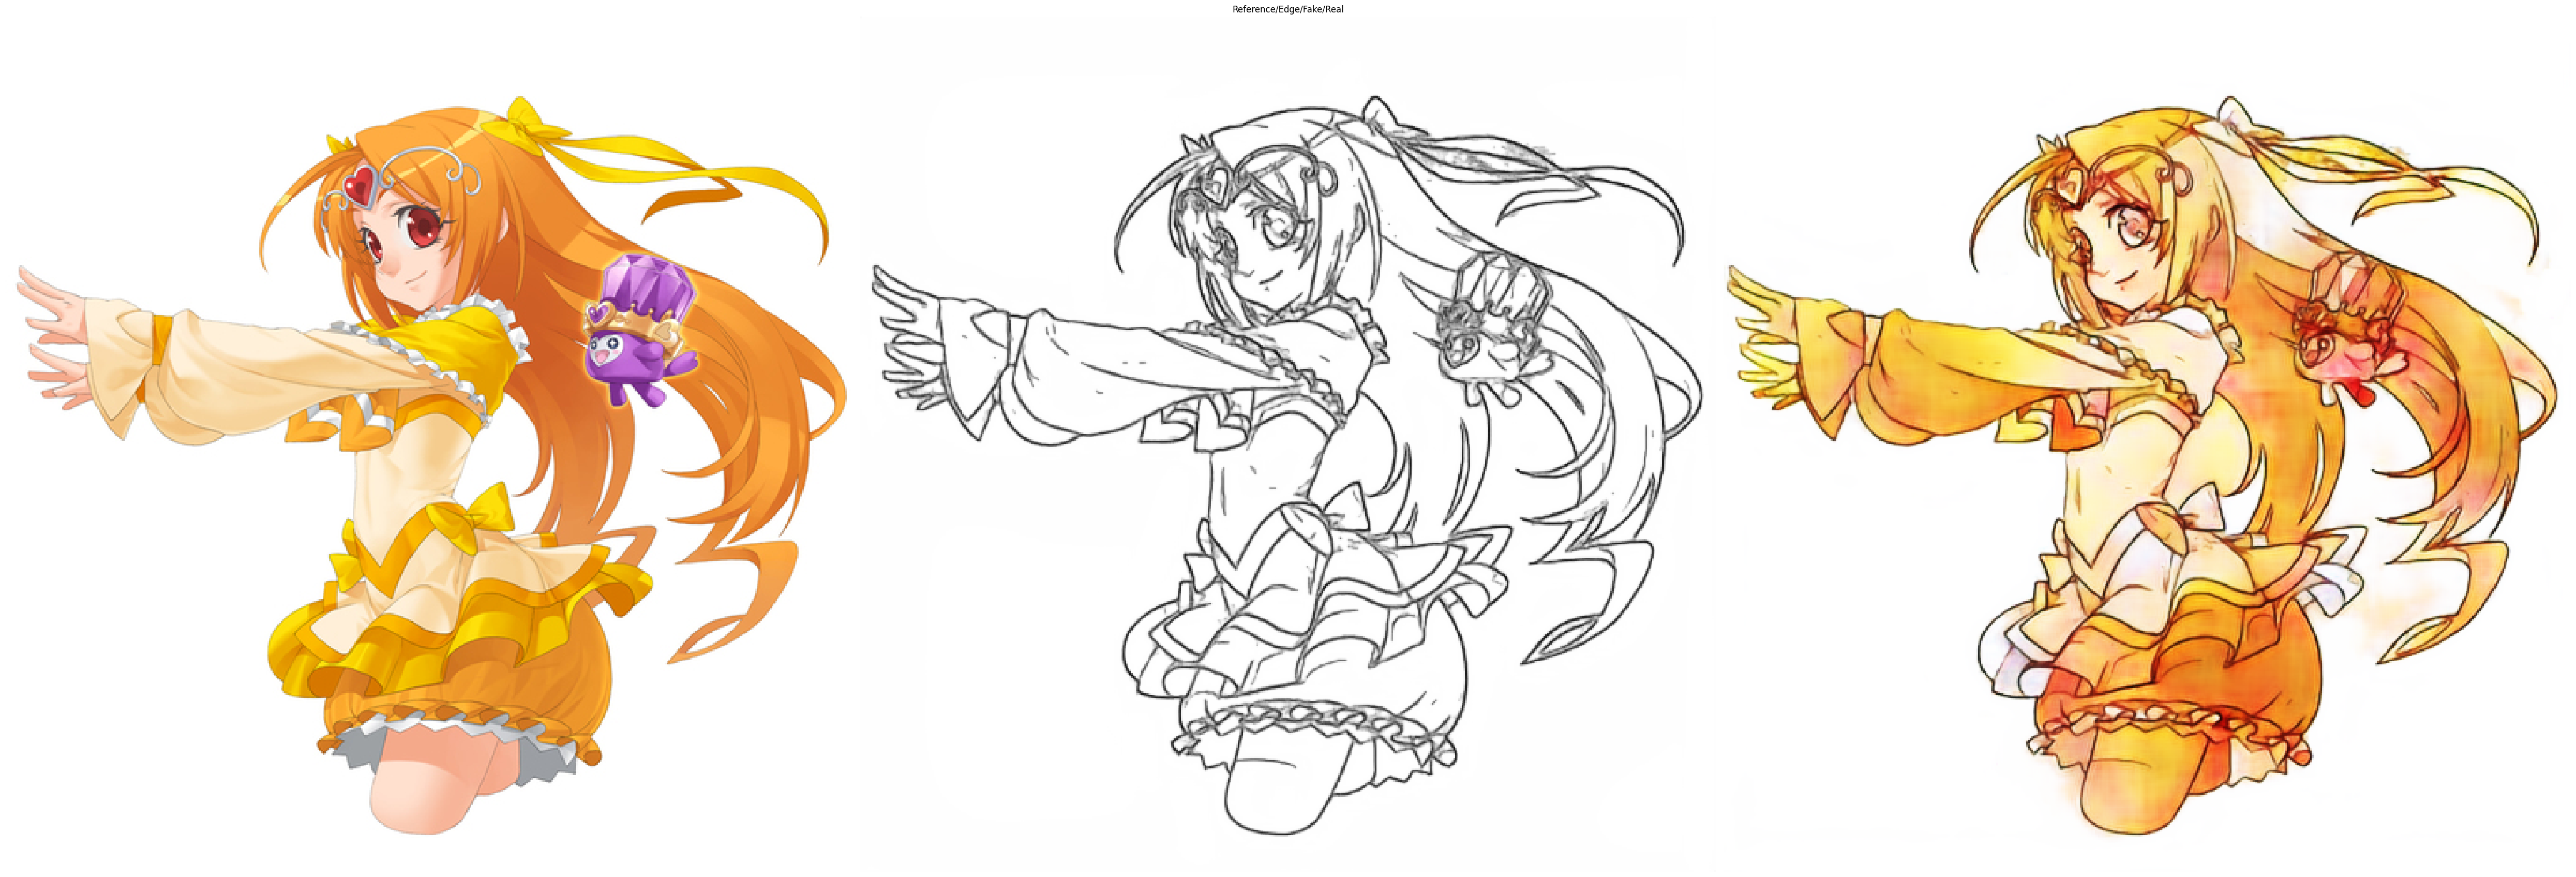

In [18]:
# A : Edge, B : Color
nc = 3 * (ncluster + 1)
netG = Sketch2Color(nc=nc, pretrained=True).to(device) 

num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

torch.backends.cudnn.benchmark = True
temp_batch_iter = iter(test_loader)

netG.eval()
temp_batch = next(temp_batch_iter)

with torch.no_grad():
    
    edge = temp_batch[0].to(device)
    real = temp_batch[1].to(device)
    reference = refer_batch[1].to(device)
    color_palette = refer_batch[2]
    input_tensor = torch.cat([edge.cpu()]+color_palette, dim=1).to(device)
    fake = netG(input_tensor)
    result = torch.cat((reference, edge, fake), dim=-1).cpu()
    
    plt.figure(figsize=(64,64))    
    plt.imshow(vutils.make_grid(result, nrow=1, padding=5, normalize=True).cpu().permute(1,2,0))    
    plt.axis("off")
    plt.title("Reference/Edge/Fake/Real")